# 人工智能的创世纪
本节内容来源于 [徒手实现多层感知器--人工智能的创世纪](https://www.bilibili.com/video/BV1mm421N7nq) ，之前有学习过杰哥的 MLP 模型搭建，
现在来看一下唐一旦老师讲的更加系统的 MLP 模型的搭建。

由于在之前已经学过部分 MLP 的内容，所以此处笔记仅做我之前没有理解的，本节所有内容围绕这一张图片（设计成矩阵一是为了同时送入多个数据，二是为了可以让 GPU 并行运算）：

![](images/多层感知器.png)

In [1]:
# 之前课纲中的内容
import torch
import torch.nn.functional as F
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1024)


class Linear:

    def __init__(self, in_features, out_features, bias=True):
        '''
        模型参数初始化
        需要注意的是，此次故意没做参数初始化的优化
        '''
        self.weight = torch.randn((in_features, out_features), requires_grad=True)  # (in_features, out_features)
        self.bias = torch.randn(out_features, requires_grad=True) if bias else None  # (             out_features)

    def __call__(self, x):
        #           x: (B, in_features)
        # self.weight:    (in_features, out_features)
        self.out = x @ self.weight  # (B, out_features)
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        '''
        返回线性模型的参数，主要用于参数迭代更新
        由于PyTorch的计算单元就是张量，
        所以此次只需将不同参数简单合并成列表即可
        '''
        if self.bias is not None:
            return [self.weight, self.bias]
        return [self.weight]


class Sigmoid:

    def __call__(self, x):
        self.out = torch.sigmoid(x)
        return self.out

    def parameters(self):
        '''
        Sigmoid函数没有模型参数
        '''
        return []

In [37]:
# 这里唐一旦老师想要去解构模仿 torch 中的 nn.torch
class Sequential:  # 这个单词有 “顺序” 的意思

    def __init__(self, layers):
        # layers 表示模型的组件
        self.layers = layers

    def __call__(self, x):
        for l in self.layers:
            x = l(x)

        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def predict_proba(self, x):
        # 计算概率预测
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()

        logits = self(x)

        # 此处说明一下为什么需要 detach().numpy()
        # 只有不需要 required_grad 的 tensor 才可以转化为 numpy
        # 而 detach 函数的作用就是将这个 tensor 复制（共享内存）为一个不需要计算梯度的 tensor
        # 有时候如果 tensor 在 gpu 上还要加一个 .cpu()
        self.prob = F.softmax(logits, dim=-1).detach().numpy()
        return self.prob


In [5]:
# x: (B, 2)
# mlp: [4, 4, 2]
model = Sequential([
    Linear(2, 4), Sigmoid(),  # (B, 4)
    Linear(4, 4), Sigmoid(),  # (B, 4)
    Linear(4, 2)
])

x = torch.randn(3, 2)
print(model(x))
print(model.predict_proba(x))

tensor([[-0.5756,  0.0729],
        [-0.5902,  0.0307],
        [-0.5812,  0.0562]], grad_fn=<AddBackward0>)
[[0.34332383 0.6566762 ]
 [0.3495752  0.6504248 ]
 [0.34582344 0.65417653]]


In [7]:
# 数据可视化的内容并不是重点这边直接 cpoy
def draw_data(data):
    '''
    将数据可视化
    '''
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    x, y = data
    label1 = x[y > 0]
    ax.scatter(label1[:, 0], label1[:, 1], marker='o')
    label0 = x[y == 0]
    ax.scatter(label0[:, 0], label0[:, 1], marker='^', color='k')
    return ax

def draw_model(ax, model):
    '''
    将模型的分离超平面可视化
    '''
    x1 = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
    x2 = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100)
    x1, x2 = np.meshgrid(x1, x2)
    y = model.predict_proba(np.c_[x1.ravel(), x2.ravel()])[:, 1]
    y = y.reshape(x1.shape)
    ax.contourf(x1, x2, y, levels=[0, 0.5], colors=['gray'], alpha=0.4)
    return ax

<Axes: >

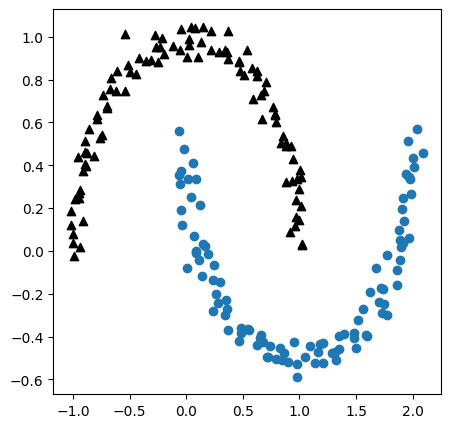

In [28]:
data = make_moons(200, noise=0.05)
draw_data(data)

In [38]:
batch_size = 20
max_steps = 40000
learning_rate = 0.1

x, y = torch.tensor(data[0]).float(), torch.tensor(data[1])  # 第二个不用加 .float() 因为交叉熵要求第二个参数是整数
model = Sequential([
    Linear(2, 4), Sigmoid(),  # (B, 4)
    Linear(4, 4), Sigmoid(),  # (B, 4)
    Linear(4, 2)
])

lossi = []

for t in range(max_steps):
    ix = (t * batch_size) % len(x)
    xx = x[ix: ix + batch_size]
    yy = y[ix: ix + batch_size]

    logits = model(xx)
    loss = F.cross_entropy(logits, yy)  # 交叉熵损失
    loss.backward()

    with torch.no_grad():
        for p in model.parameters():
            p -= learning_rate * p.grad
            p.grad = None

    lossi.append(loss.item())

<Axes: >

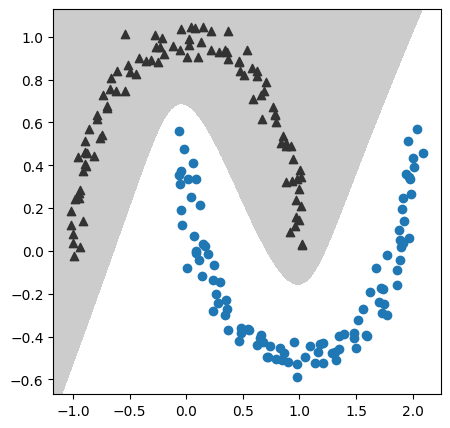

In [39]:
ax = draw_data(data)
draw_model(ax, model)

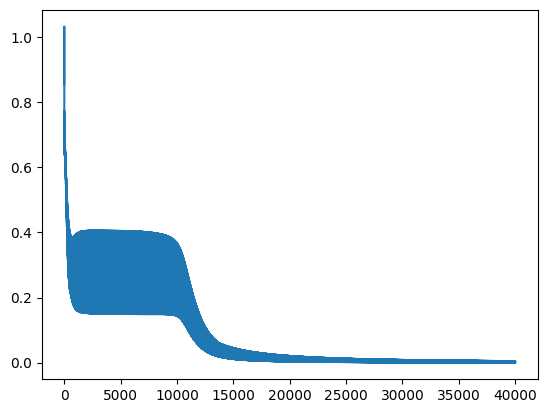

In [40]:
plt.plot(lossi)

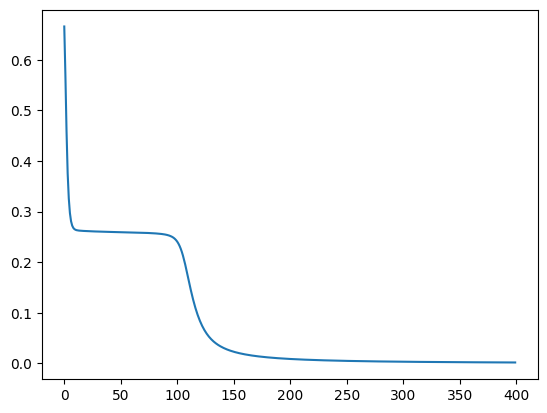

In [42]:
# 平均点代表损失
plt.plot(torch.tensor(lossi).view(-1, 100).mean(dim=-1))

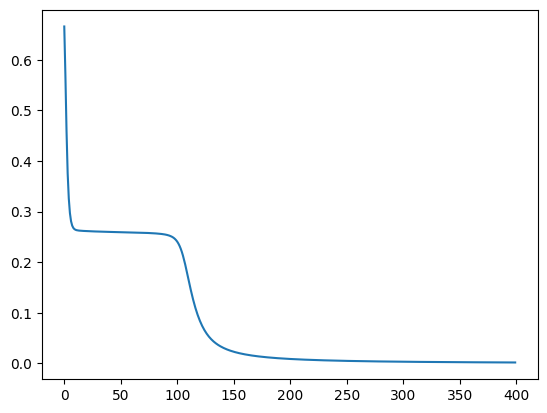

In [52]:
plt.plot([sum(lossi[i: i + 100]) / len(lossi[i: i + 100]) for i in range(0, len(lossi), 100) if len(lossi[i: i + 100]) != 0])